# EPIC BLOCK 3 - Predicting Heart Disease

# Initial setup

In [67]:
import pandas as pd

df_raw = pd.read_csv('heart_data.csv')
print("Column Names:")
for column in df_raw.columns:
    print(column)

Column Names:
HeartDisease
BMI
Smoking
AlcoholDrinking
Stroke
PhysicalHealth
MentalHealth
DiffWalking
Sex
AgeCategory
Race
Diabetic
PhysicalActivity
GenHealth
SleepTime
Asthma
KidneyDisease
SkinCancer


# Preprocessing
## Check for null values

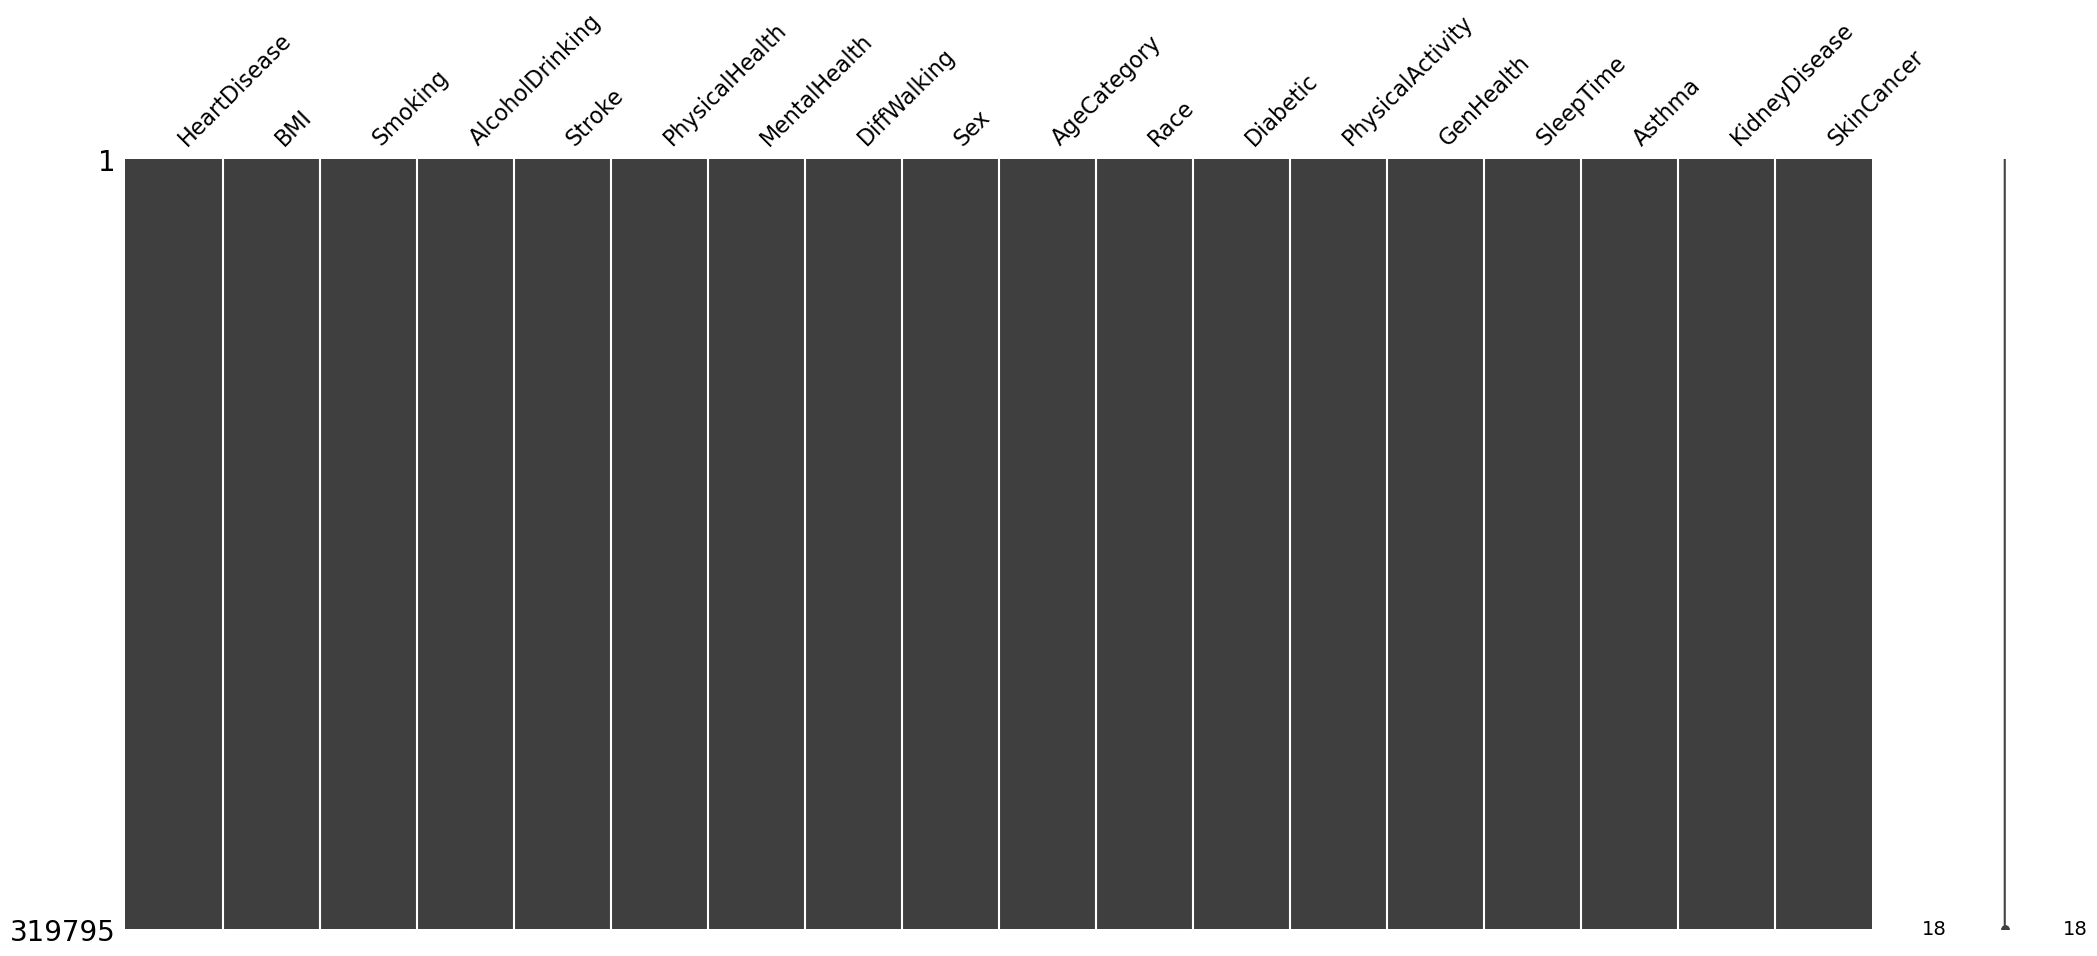

<Figure size 1500x900 with 0 Axes>

In [68]:
import missingno as msno
import matplotlib.pyplot as plt

msno.matrix(df_raw)
plt.figure(figsize=(15, 9))
plt.show()

As we can see from the above graph, the dataset has no null values.

## Balancing

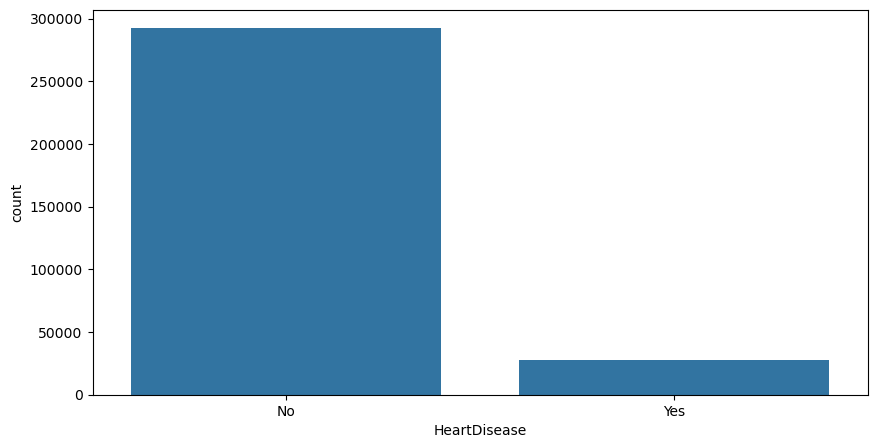

In [69]:
import seaborn as sns
import matplotlib.pyplot as plt

df = df_raw.copy()

plt.figure(figsize=(10, 5))
sns.countplot(data=df, x='HeartDisease', order=['No', 'Yes'])
plt.show()

In the unbalanced dataset, almost 92% of the samples do not have heart disease. Training our models on this data will result in high accuracy, but low recall. This will result in overfitting and many false negatives, which is especially dangerous for a model predicting heart disease.
We shall therefore rebalance the dataset to try and improve recall.

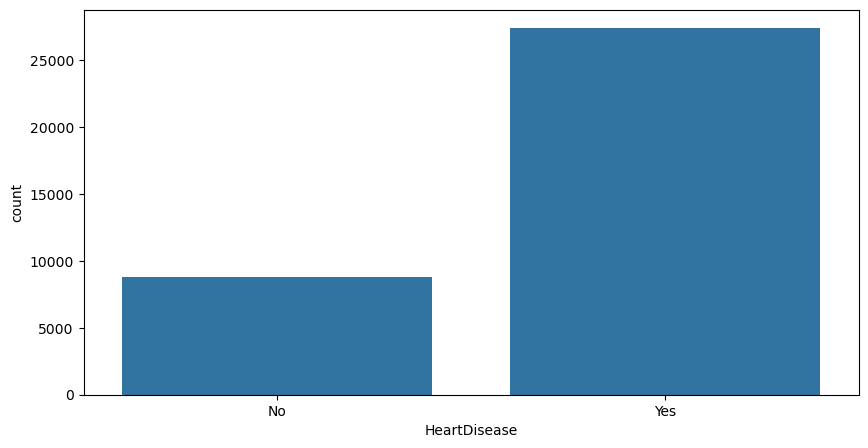

In [70]:
# Calculate the number of rows to delete
false_output_removed = 0.97
num_rows_to_delete = int(false_output_removed * len(df[df['HeartDisease'] == 'No']))

# Get indices of rows where HeartDisease is "No"
indices_to_delete = df[df['HeartDisease'] == 'No'].sample(n=num_rows_to_delete).index

# Drop rows by indices
df.drop(indices_to_delete, inplace=True)
df_raw_balanced = df.copy()

plt.figure(figsize=(10, 5))
sns.countplot(data=df, x='HeartDisease', order=['No', 'Yes'])
plt.show()

## Label Encoding (Convert hierarchal categorical values to numerical indexes)

In [71]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()

# Apply label encoding to each categorical column
categorical_columns = df.select_dtypes(include=['object']).columns
for col in categorical_columns:
    df[col] = label_encoder.fit_transform(df[col])

df.head()

,HeartDisease,BMI,Smoking,AlcoholDrinking,Stroke,PhysicalHealth,MentalHealth,DiffWalking,Sex,AgeCategory,Race,Diabetic,PhysicalActivity,GenHealth,SleepTime,Asthma,KidneyDisease,SkinCancer
5,1,28.87,1,0,0,6.0,0.0,1,0,11,2,0,0,1,12.0,0,0,0
10,1,34.30,1,0,0,30.0,0.0,1,1,8,5,2,0,3,15.0,1,0,0
11,0,28.71,1,0,0,0.0,0.0,0,0,7,5,0,1,4,5.0,0,0,0
12,0,28.37,1,0,0,0.0,0.0,1,1,11,5,2,1,4,8.0,0,0,0
17,0,22.59,1,0,0,0.0,30.0,1,1,10,5,1,1,2,8.0,0,0,0


## Correlation Matrix
Correlation matrices display information about how much columns correlate with each other. A high value indicates that one feature is capable of describing another, which could indicate redundancy in the dataset.

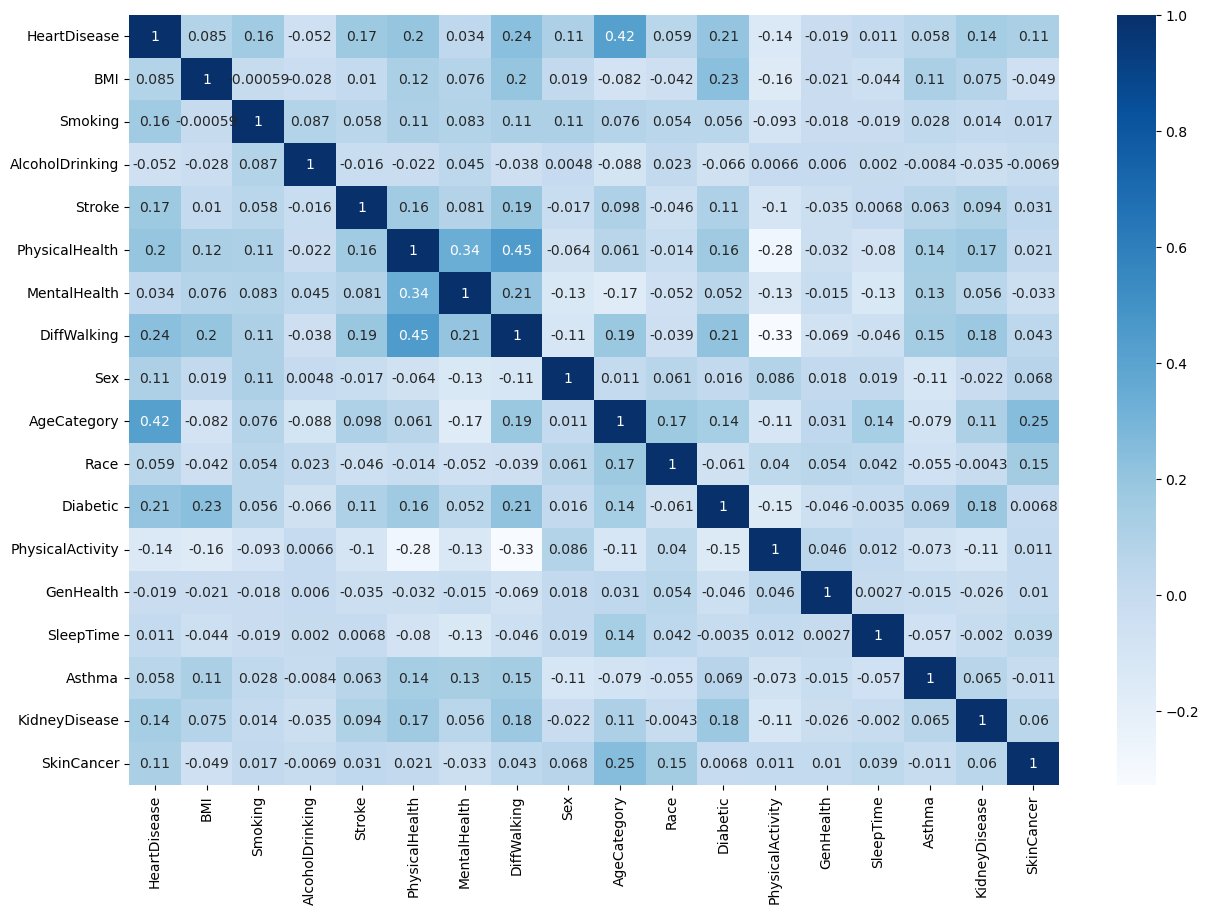

In [72]:
corr_matrix = df.corr()
plt.figure(figsize=(15, 10))
sns.heatmap(corr_matrix, annot=True, cmap='Blues')
plt.show()

There are some moderate correlations, but nothing that would warrant removing features for redundancy. One of the most interesting correlations here is that between age and heart disease, which already hints that heart disease is linked with aging. This should be explored more in the visualisation section.

# VISUALISATION

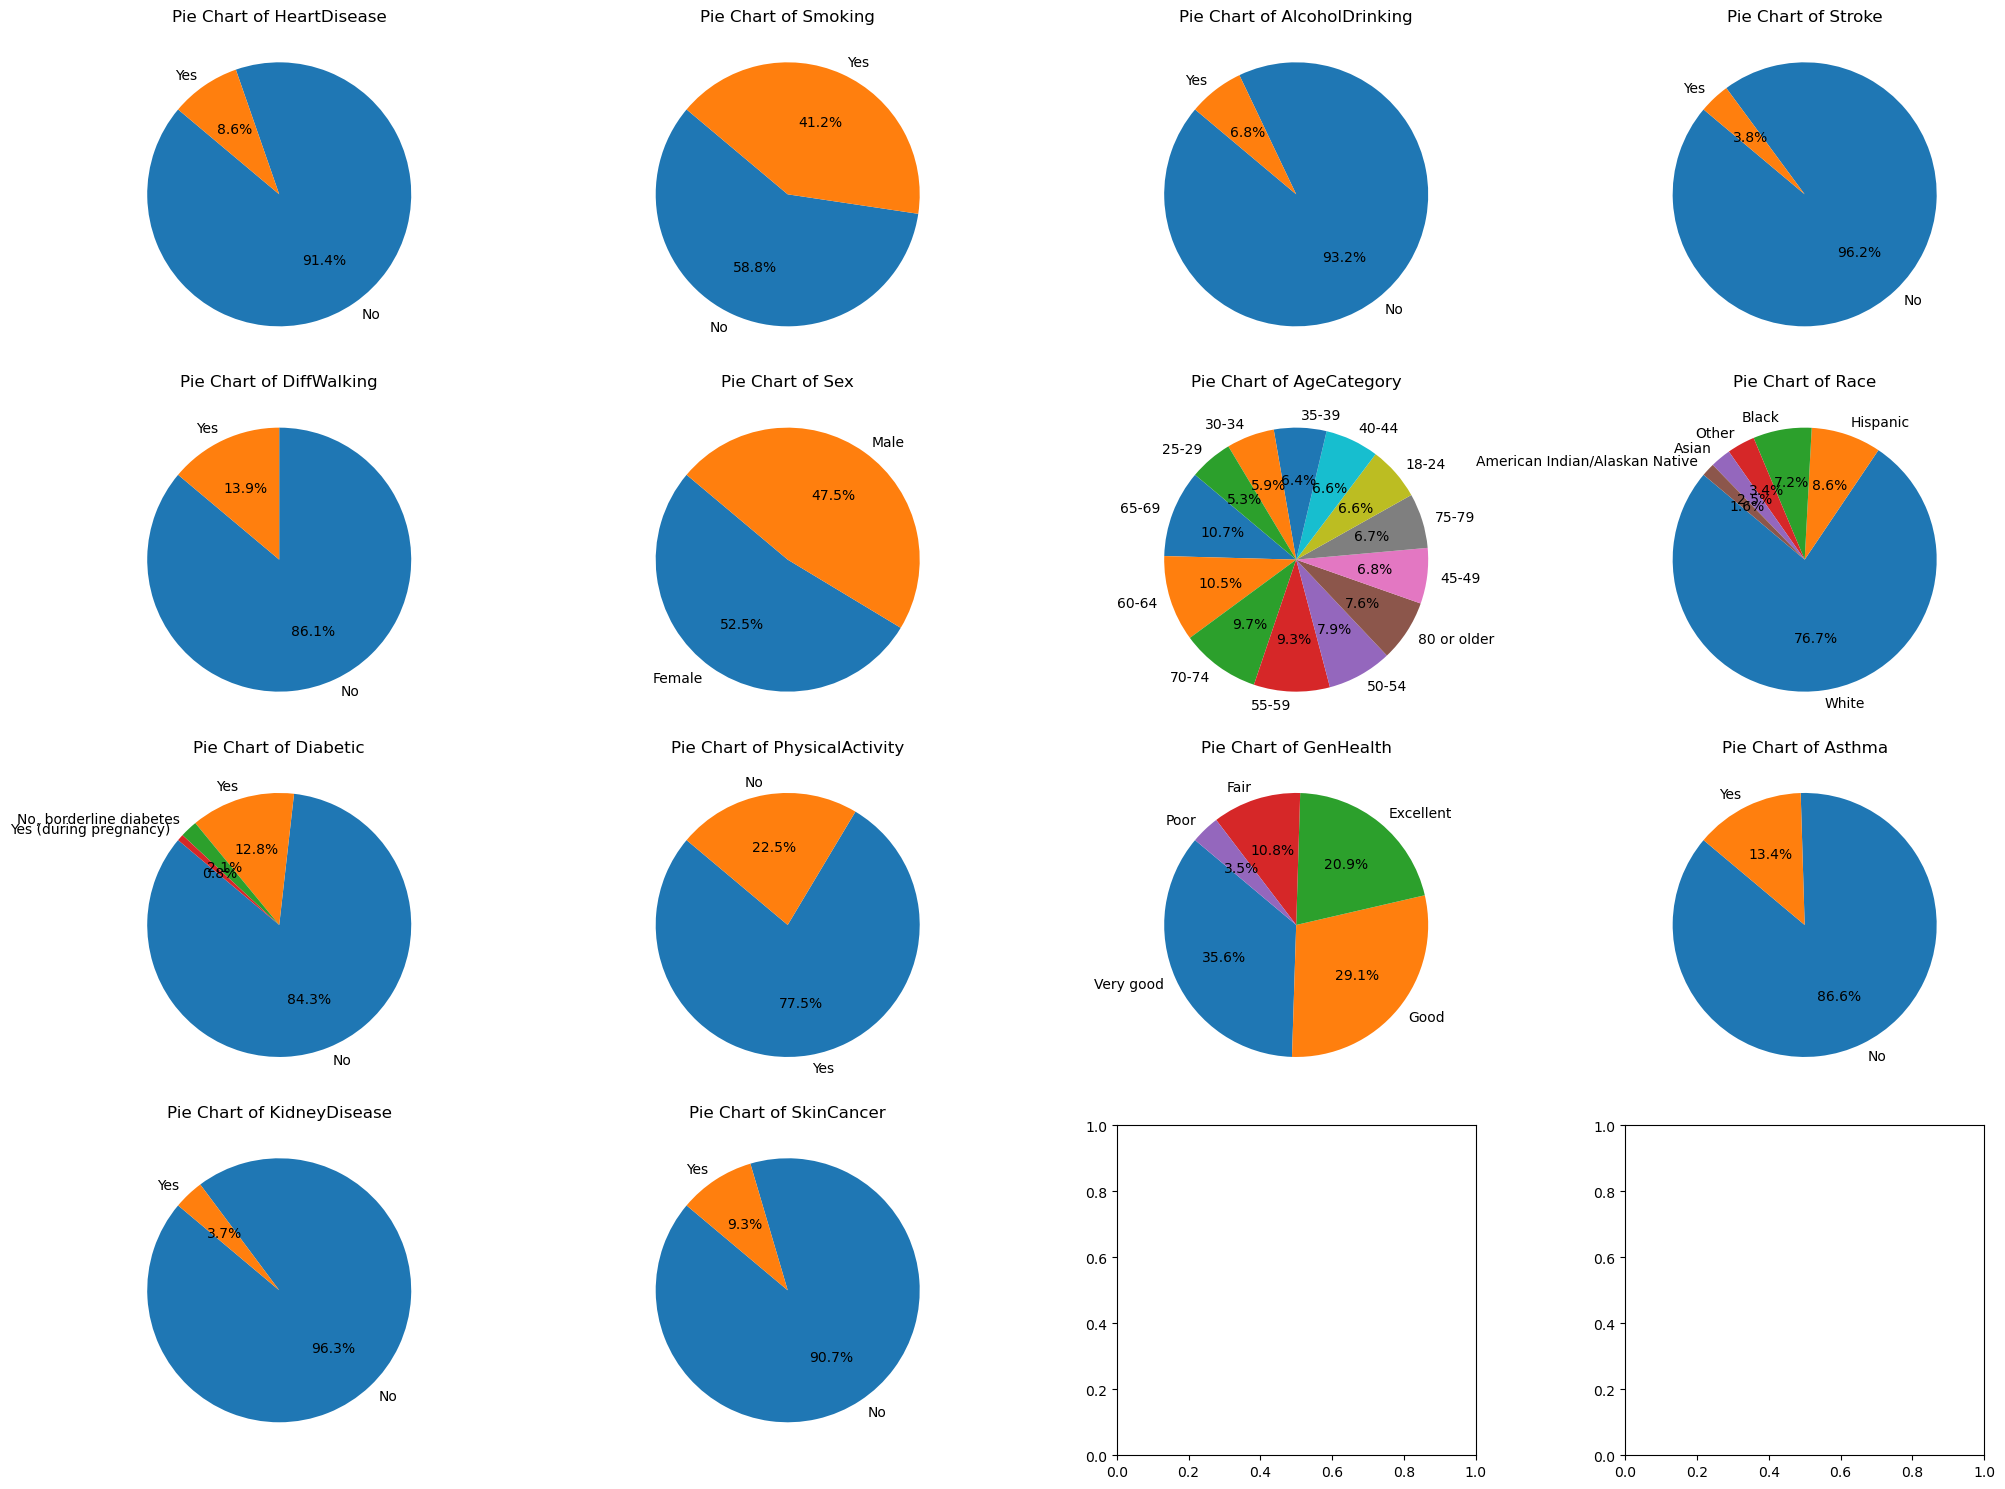

In [73]:
import matplotlib.pyplot as plt

categorical_features = ['HeartDisease', 'Smoking', 'AlcoholDrinking', 'Stroke', 'DiffWalking', 'Sex', 'AgeCategory',
                        'Race', 'Diabetic', 'PhysicalActivity', 'GenHealth', 'Asthma', 'KidneyDisease', 'SkinCancer']
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(20, 15))

for i, feature in enumerate(categorical_features):
    counts = df_raw[feature].value_counts()
    ax = axes[i // 4, i % 4]
    ax.pie(counts, labels=counts.index, autopct='%1.1f%%', startangle=140)
    ax.set_title(f'Pie Chart of {feature}')

plt.tight_layout()
plt.show()


We can make a couple of conclusions from the above charts:
- The vast majority of samples did not have heart disease, skin cancer or kidney disease. This makes sense with how the data was collected, being a phone-in system where the majority of participants would be healthy.
- This is supported by the General Health data point, which is skewed toward those in good and very good health.
- The split is roughly 50/50 between male and female.
- There is quite a high representation from Caucasian respondents, which matches the proportion of the USA who are white. As race can have an effect on the risk of developing heart disease, this will be something to note in our conclusions.
- There is a very good spread of ages, with similar amounts in each category.

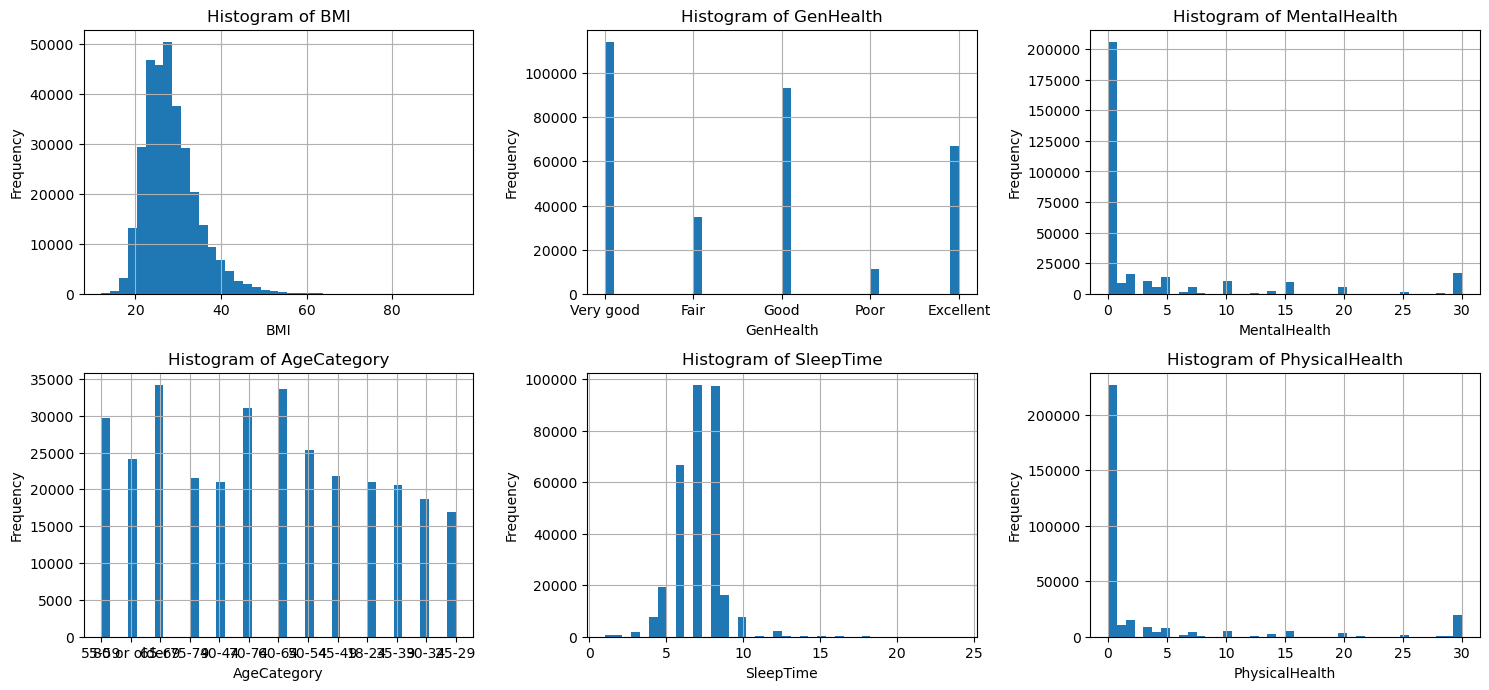

In [74]:
labels_of_interest = ['BMI', 'GenHealth', 'MentalHealth', 'AgeCategory', 'SleepTime', 'PhysicalHealth']

num_plots = len(labels_of_interest)
num_cols = 3
num_rows = 3

fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 10))
axes = axes.flatten()

for i, label in enumerate(labels_of_interest):
    df_raw[label].hist(bins=40, ax=axes[i])
    axes[i].set_title(f'Histogram of {label}')
    axes[i].set_xlabel(label)
    axes[i].set_ylabel('Frequency')

for i in range(num_plots, num_rows * num_cols):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()


These graphs give us a better look into the spread of several of the datasets. 
- We can see that BMI is skewed right, although there are quite a few entries who would be classified as 'obese'
- Additionally, it can also be noted that most respondents reported having physical or mental difficulty either 0 or 30 days within the last 30. From this we can infer that most were perfectly healthy, while the majority of the remainder were quite unwell.

Number of rows with Heart Disease: 27373
Number of rows without Heart Disease: 292422


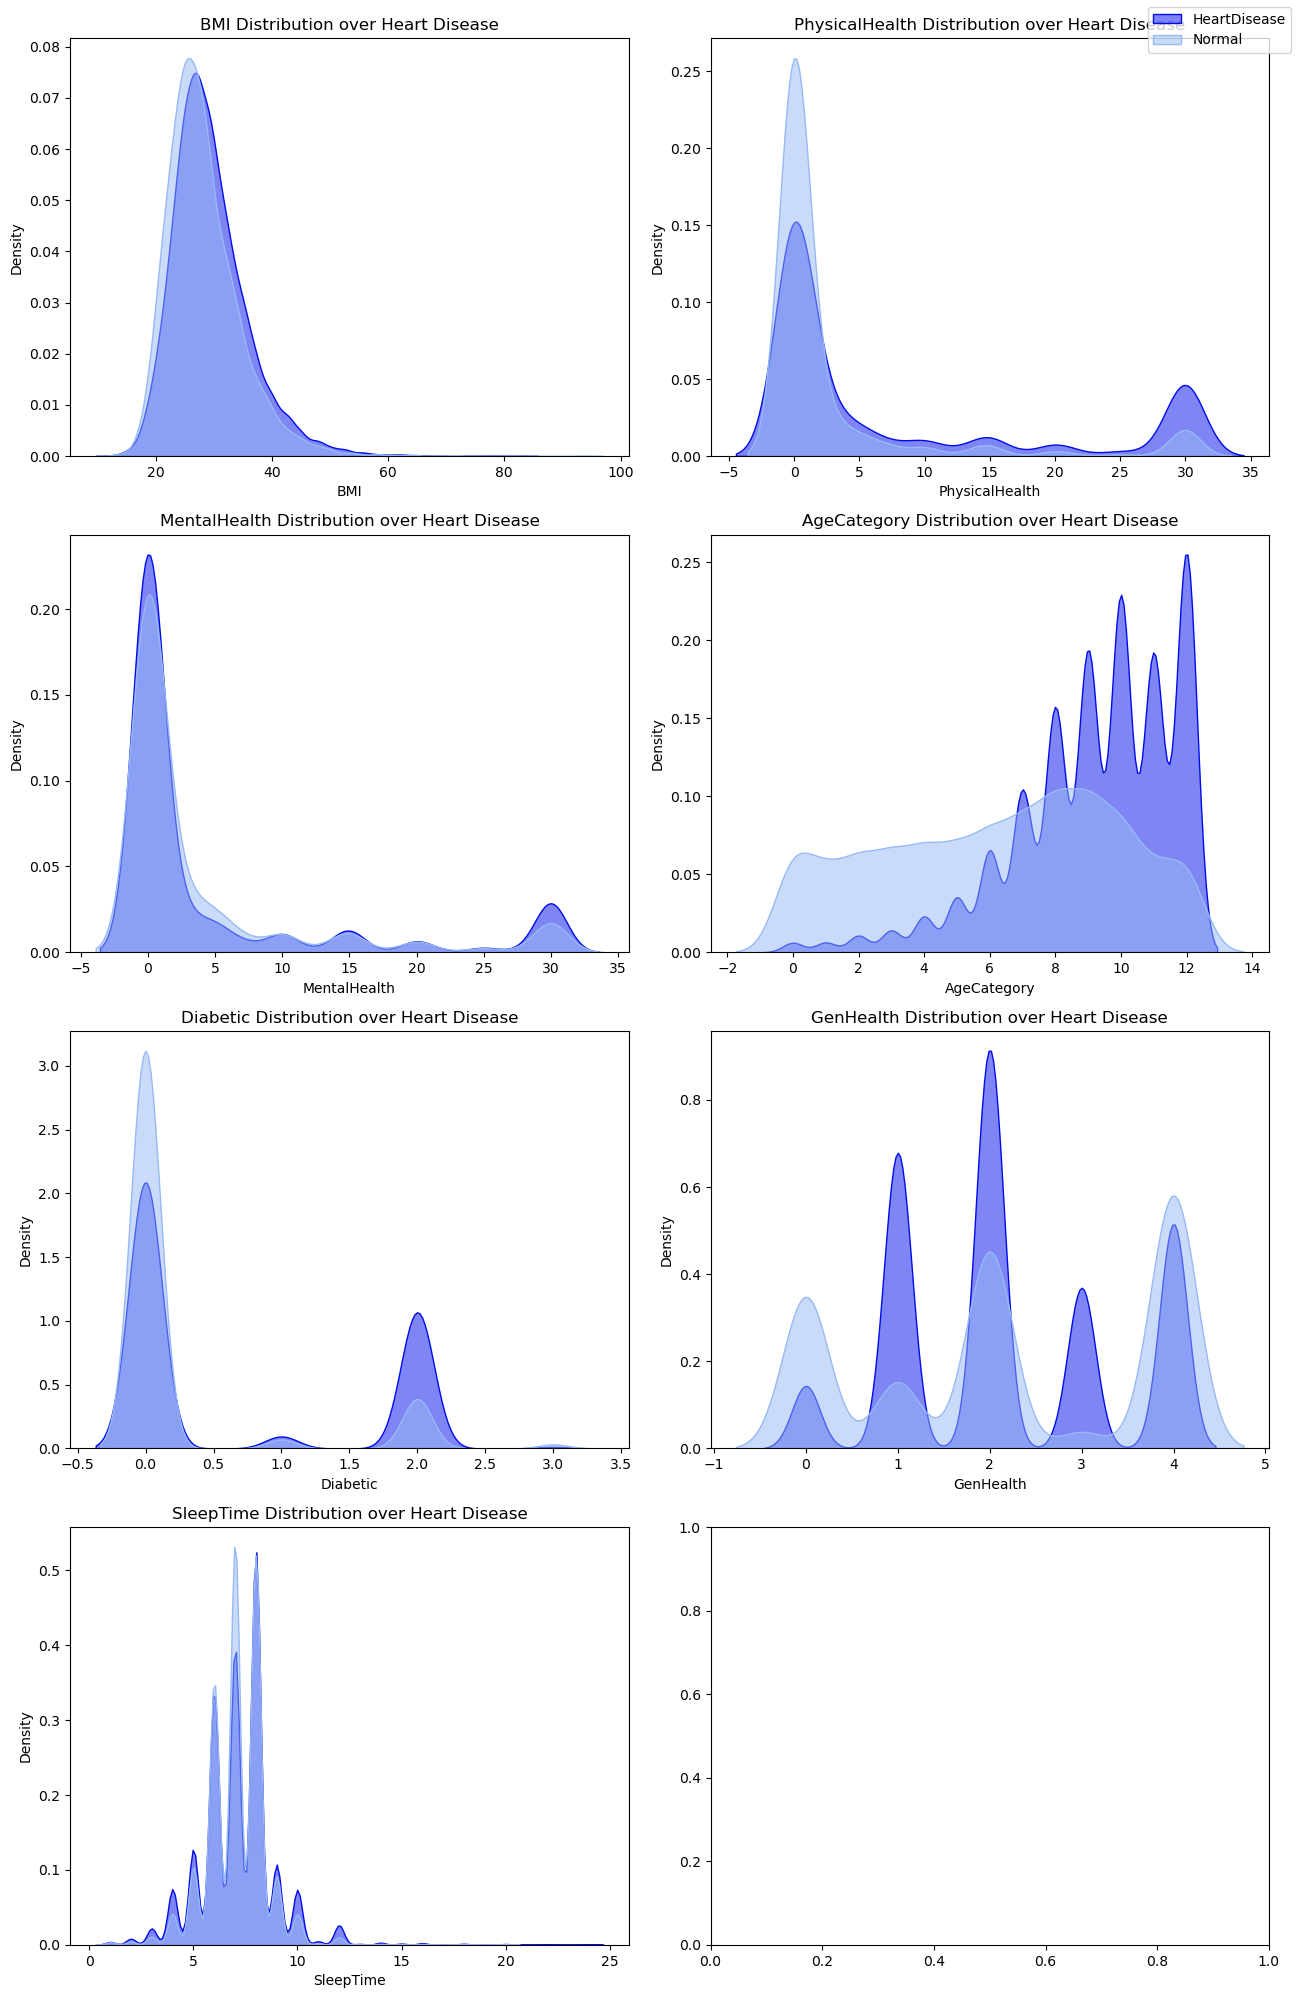

In [75]:
import matplotlib.pyplot as plt
import seaborn as sns

df5050 = df_raw.copy()
heart_disease_true_count = df5050[df5050['HeartDisease'] == 'Yes'].shape[0]
heart_disease_false_count = df5050[df5050['HeartDisease'] == 'No'].shape[0]
print(f"Number of rows with Heart Disease: {heart_disease_true_count}")
print(f"Number of rows without Heart Disease: {heart_disease_false_count}")
false_remove = heart_disease_true_count / heart_disease_false_count
num_rows_to_delete = int(false_remove * len(df5050[df5050['HeartDisease'] == 'No']))

# Get indices of rows where HeartDisease is "No"
indices_to_delete = df5050[df5050['HeartDisease'] == 'No'].sample(n=num_rows_to_delete).index

# Drop rows by indices
df5050.drop(indices_to_delete, inplace=True)

columns_to_exclude = ['Sex', 'Smoking', 'AlcoholDrinking', 'Stroke', 'DiffWalking', 'PhysicalActivity', 'Asthma',
                      'KidneyDisease', 'SkinCancer', 'Race']
columns_to_plot = [col for col in df5050.columns if col not in ['HeartDisease'] + columns_to_exclude]

fig, axes = plt.subplots(nrows=(len(columns_to_plot) + 1) // 2, ncols=2, figsize=(13, 20))

for idx, column in enumerate(columns_to_plot):
    row_idx = idx // 2
    col_idx = idx % 2

    sns.kdeplot(df[df["HeartDisease"] == 1][column], alpha=0.5, fill=True, color="#000CEB", label="HeartDisease",
                ax=axes[row_idx, col_idx])
    sns.kdeplot(df[df["HeartDisease"] == 0][column], alpha=0.5, fill=True, color="#97B9F4", label="Normal",
                ax=axes[row_idx, col_idx])

    axes[row_idx, col_idx].set_xlabel(column)
    axes[row_idx, col_idx].set_ylabel("Density")
    axes[row_idx, col_idx].set_title(f"{column} Distribution over Heart Disease")

# Manually adding legend
handles, labels = axes[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right')

plt.tight_layout()
plt.show()


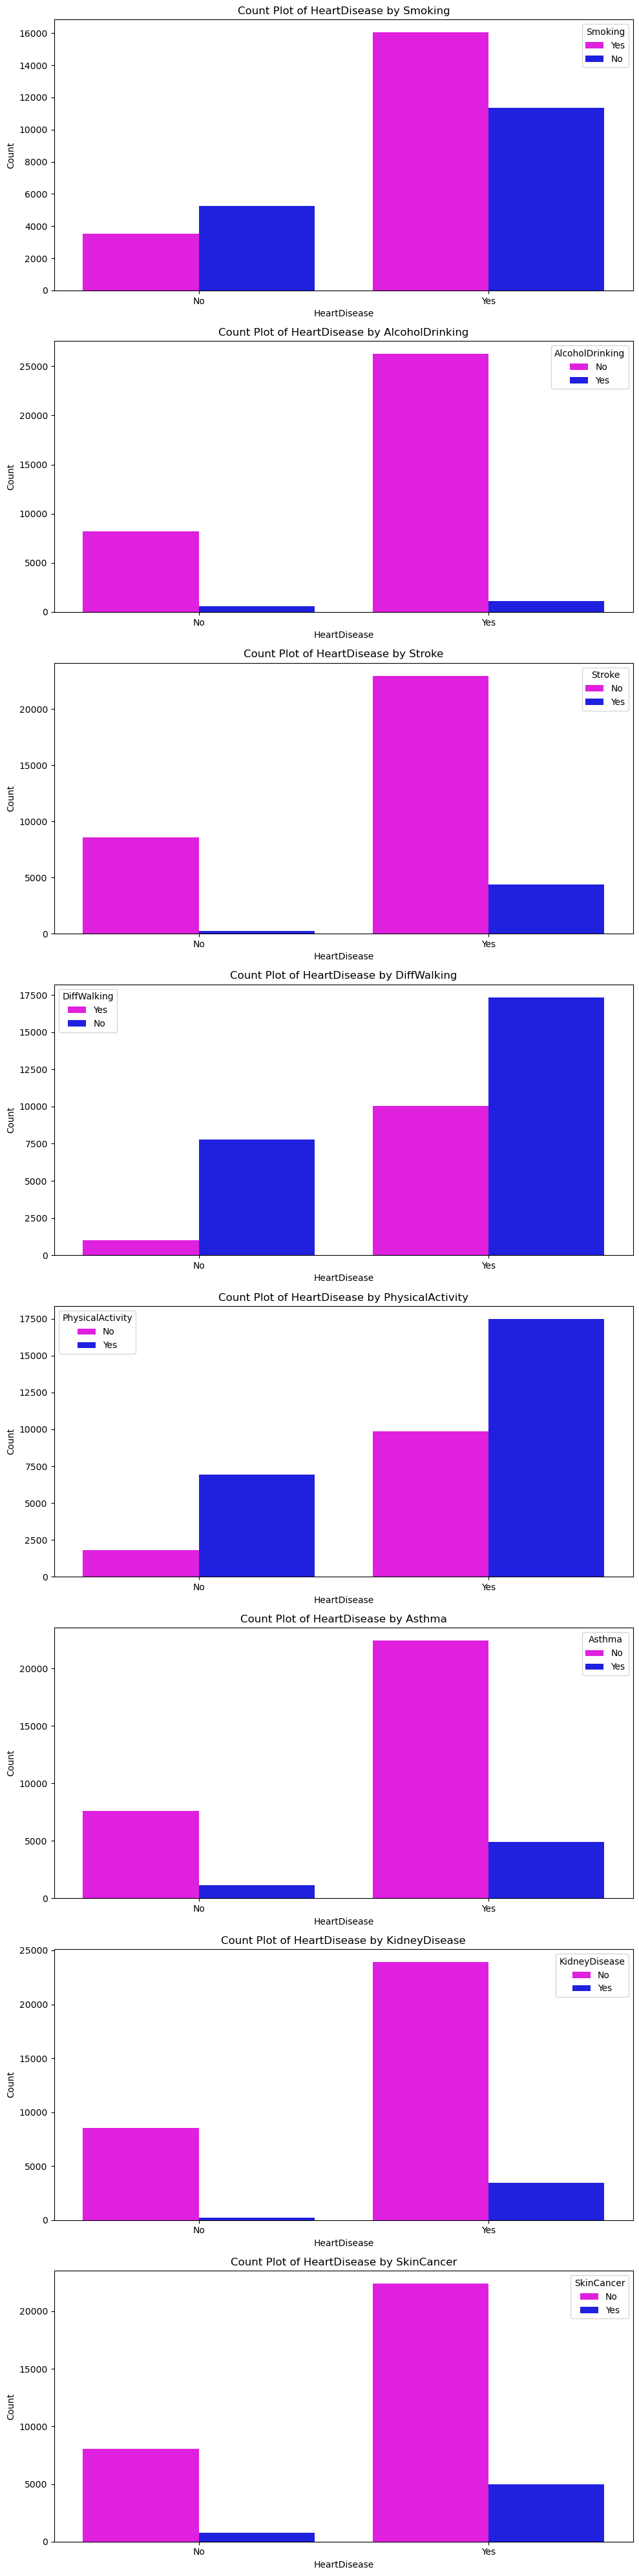

In [76]:
import seaborn as sns
import matplotlib.pyplot as plt

# Features of interest
features_of_interest = ['Smoking', 'AlcoholDrinking', 'Stroke', 'DiffWalking', 'PhysicalActivity', 'Asthma',
                        'KidneyDisease', 'SkinCancer']

# Define custom palette with more colors
custom_palette = ["#ff00ff", "#0000ff"]

# Create subplots
fig, axes = plt.subplots(nrows=len(features_of_interest), ncols=1, figsize=(10, 5 * len(features_of_interest)))

# Iterate over features
for i, feature in enumerate(features_of_interest):
    # Use the balanced data, as with unbalanced data we just get one large bar on the left
    sns.countplot(data=df_raw_balanced, x='HeartDisease', hue=feature, palette=custom_palette, ax=axes[i],
                  order=['No', 'Yes'])
    axes[i].set_title(f'Count Plot of HeartDisease by {feature}')
    axes[i].set_xlabel('HeartDisease')
    axes[i].set_ylabel('Count')

plt.tight_layout()
plt.show()


The above graphs also offer some interesting insights. Perhaps the most telling is the fact that smoking led to a serious increase in the risk of developing heart disease.
We can perform calculations to evaluate the exact impact of this.

In [77]:
total_yes = df[df['HeartDisease'] == 1].shape[0]
print('Smokes and has heart disease: ', df[(df["HeartDisease"] == 1) & (df["Smoking"] == 1)].shape[0] / total_yes)
print('Smokes and doesnt have heart disease: ', df[(df["HeartDisease"] == 0) & (df["Smoking"] == 0)].shape[0] / total_yes)


Smokes and has heart disease:  0.5858692872538633
Smokes and doesnt have heart disease:  0.19194096372337704


Almost 60% of those with heart disease had history of smoking. This is an interesting insight that could lead to methods of preventing heart disease in the future.

# Model Building

### Initialising

In [78]:
from sklearn.model_selection import train_test_split

X = df.drop(columns=['HeartDisease'])
y = df['HeartDisease']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Random Forest classification using feature importances

By Selecting certain features we try to hypertune them more to produce higher accuracy/better recall

In [79]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

rf_model = RandomForestClassifier(n_estimators=600, random_state=42)
rf_model.fit(X_train, y_train)
y_pred = rf_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy on testing set (using all features):", accuracy)
N = 10
feature_importances = rf_model.feature_importances_

# Select most important features
top_n_features_indices = feature_importances.argsort()[::-1][:N]
top_n_features_names = X.columns[feature_importances.argsort()[::-1][:N]]

print("Top", N, "most important features to heart diesease:")
for index, feature_name in zip(top_n_features_indices, top_n_features_names):
    print("Index:", index, " - Feature:", feature_name)
X_train_selected = X_train.iloc[:, top_n_features_indices]
X_test_selected = X_test.iloc[:, top_n_features_indices]

# train the Random Forest classifier with selected features
rf_model_selected = RandomForestClassifier(n_estimators=600, random_state=42)
rf_model_selected.fit(X_train_selected, y_train)

# Predictions on the testing set using selected features
y_pred_selected = rf_model_selected.predict(X_test_selected)

accuracy_selected = accuracy_score(y_test, y_pred_selected)
print("Accuracy on testing set (using selected features):", accuracy_selected)

Accuracy on testing set (using all features): 0.822268326417704
Top 10 most important features to heart diesease:
Index: 0  - Feature: BMI
Index: 8  - Feature: AgeCategory
Index: 13  - Feature: SleepTime
Index: 12  - Feature: GenHealth
Index: 4  - Feature: PhysicalHealth
Index: 5  - Feature: MentalHealth
Index: 9  - Feature: Race
Index: 10  - Feature: Diabetic
Index: 6  - Feature: DiffWalking
Index: 7  - Feature: Sex
Accuracy on testing set (using selected features): 0.8118948824343015


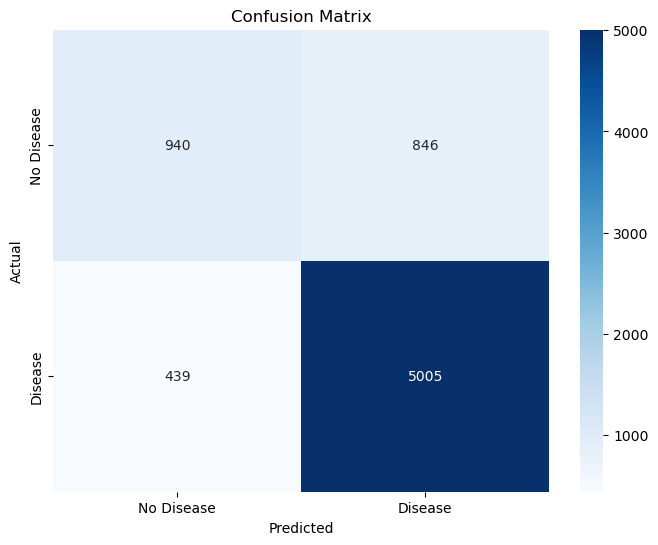

In [80]:
from sklearn.metrics import confusion_matrix

# Create confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=['No Disease', 'Disease'],
            yticklabels=['No Disease', 'Disease'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

#0.92 - 1461 861


c:\Users\deane\anaconda3\envs\DAML\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


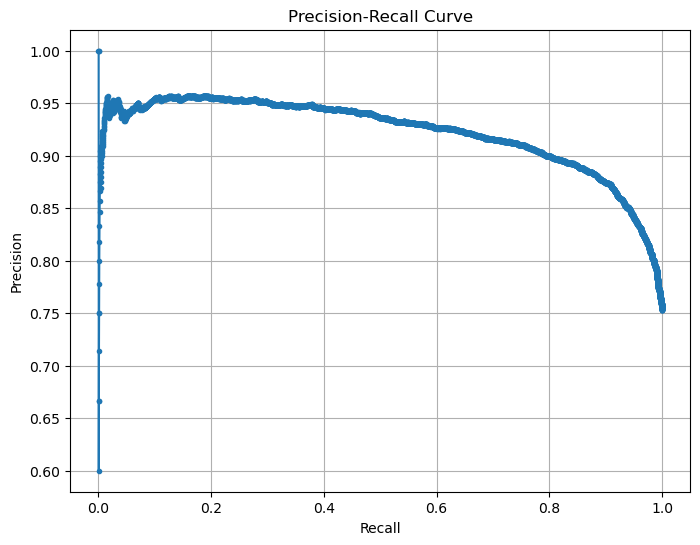

In [81]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import precision_recall_curve


mlp_model = MLPClassifier(hidden_layer_sizes=(100,), activation='relu', solver='adam', random_state=42)
mlp_model.fit(X_train, y_train)

y_proba = mlp_model.predict_proba(X_test)[:, 1]
precision, recall, _ = precision_recall_curve(y_test, y_proba)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.grid(True)
plt.show()

## Random Forest Report

In [82]:
from sklearn.metrics import classification_report

report = classification_report(y_test, y_pred)
print(report)

file_path = "classification_report.txt"

with open(file_path, "a") as file:
    file.write("Random Forest Classification Report\nFalse Output Removed: " + str(
        false_output_removed) + "\n" + report + "\n\n")

print("Classification report saved to:", file_path)

              precision    recall  f1-score   support

           0       0.68      0.53      0.59      1786
           1       0.86      0.92      0.89      5444

    accuracy                           0.82      7230
   macro avg       0.77      0.72      0.74      7230
weighted avg       0.81      0.82      0.81      7230

Classification report saved to: classification_report.txt


## Logistic Regression

In [83]:
from sklearn.linear_model import LogisticRegression

logistic_model = LogisticRegression(max_iter=10000, random_state=42)

logistic_model.fit(X_train, y_train)
y_pred = logistic_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy on testing set (using all features):", accuracy)


Accuracy on testing set (using all features): 0.8315352697095436


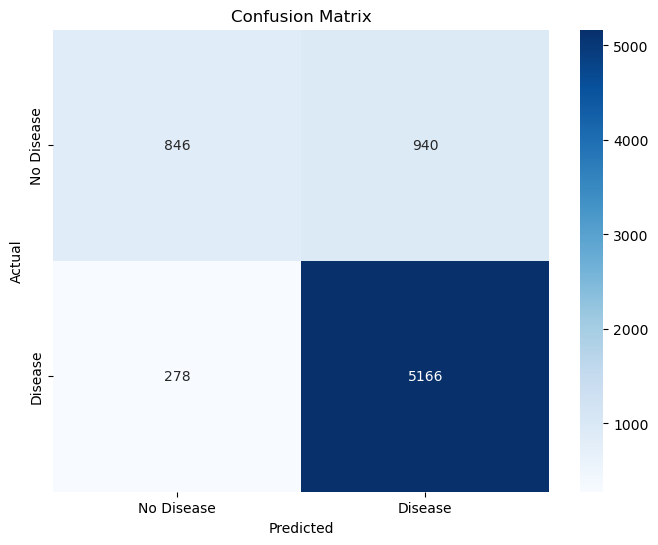

In [84]:
conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=['No Disease', 'Disease'],
            yticklabels=['No Disease', 'Disease'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

c:\Users\deane\anaconda3\envs\DAML\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


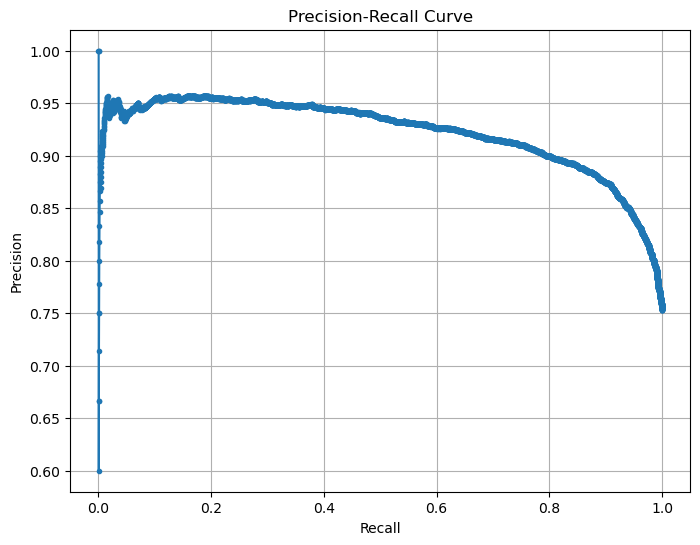

In [85]:

mlp_model = MLPClassifier(hidden_layer_sizes=(100,), activation='relu', solver='adam', random_state=42)
mlp_model.fit(X_train, y_train)

y_proba = mlp_model.predict_proba(X_test)[:, 1]
precision, recall, _ = precision_recall_curve(y_test, y_proba)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.grid(True)
plt.show()

## Logistic Regression Report

In [86]:
report = classification_report(y_test, y_pred)
print(report)

with open(file_path, "a") as file:
    file.write(
        "Logistic Regression Report\nFalse Output Removed: " + str(false_output_removed) + "\n" + report + "\n\n")

print("Classification report saved to:", file_path)

              precision    recall  f1-score   support

           0       0.75      0.47      0.58      1786
           1       0.85      0.95      0.89      5444

    accuracy                           0.83      7230
   macro avg       0.80      0.71      0.74      7230
weighted avg       0.82      0.83      0.82      7230

Classification report saved to: classification_report.txt


## Nueral Network hypertuned using gridsearch to find the best parametres

In [87]:
from sklearn.neural_network import MLPClassifier

mlp_model = MLPClassifier(hidden_layer_sizes=(200,), activation='relu', solver='adam', alpha=0.01, random_state=42,
                          max_iter=1000)

mlp_model.fit(X_train, y_train)
y_pred = mlp_model.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy on testing set (using all features):", accuracy)


Accuracy on testing set (using all features): 0.8322268326417704


c:\Users\deane\anaconda3\envs\DAML\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


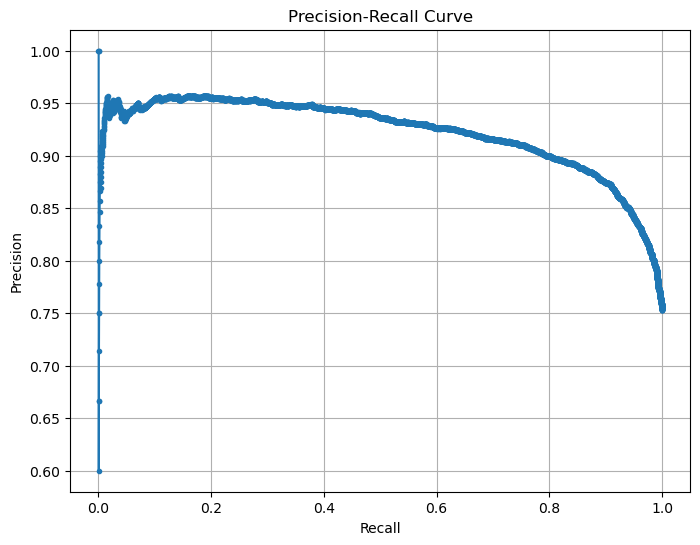

In [88]:
mlp_model = MLPClassifier(hidden_layer_sizes=(100,), activation='relu', solver='adam', random_state=42)
mlp_model.fit(X_train, y_train)

y_proba = mlp_model.predict_proba(X_test)[:, 1]
precision, recall, _ = precision_recall_curve(y_test, y_proba)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.grid(True)
plt.show()


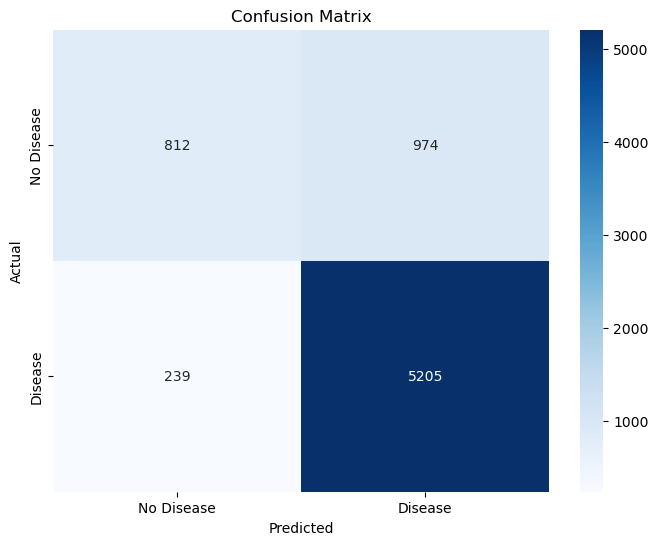

In [89]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Create confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=['No Disease', 'Disease'],
            yticklabels=['No Disease', 'Disease'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


#0.92 - 1501 995

## Neural Network Report

In [90]:
report = classification_report(y_test, y_pred)
print(report)

with open(file_path, "a") as file:
    file.write("Neural Network Report\nFalse Output Removed: " + str(false_output_removed) + "\n" + report + "\n\n")

print("Classification report saved to:", file_path)

              precision    recall  f1-score   support

           0       0.77      0.45      0.57      1786
           1       0.84      0.96      0.90      5444

    accuracy                           0.83      7230
   macro avg       0.81      0.71      0.73      7230
weighted avg       0.83      0.83      0.82      7230

Classification report saved to: classification_report.txt


## Gradient Boosting Classifier with hyperparameter tuning

In [91]:
from sklearn.ensemble import GradientBoostingClassifier


# Initialize the Gradient Boosting classifier
gbm_model = GradientBoostingClassifier(n_estimators=166, learning_rate=0.1, max_depth=3, random_state=42)

# Fit the model
gbm_model.fit(X_train, y_train)

# Make predictions
y_pred = gbm_model.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy on testing set:", accuracy)

# Fitting 5 folds for each of 27 candidates, totalling 135 fits
# [CV] END ..learning_rate=0.01, max_depth=5, n_estimators=100; total time=   3.8s
# ...
# [CV] END ..learning_rate=0.2, max_depth=15, n_estimators=200; total time=  56.9s
# Best hyperparameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100}
# Accuracy on testing set with best model: 0.7694504628717747

#Using these results further manually tuned estimators to 166 and max_depth to 3 to 
#get accuracy of 0.7744731140437267 at the original balance of 92% of false output removed

Accuracy on testing set: 0.837344398340249


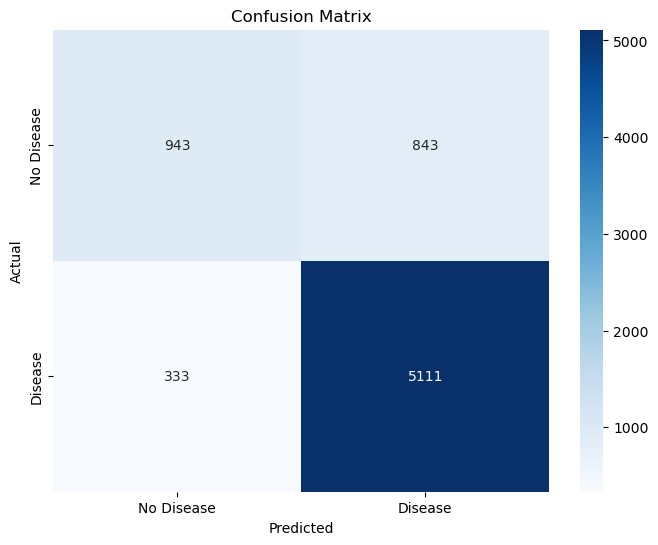

In [92]:
# Create confusion matrix
from sklearn.metrics import confusion_matrix

conf_matrix = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=['No Disease', 'Disease'],
            yticklabels=['No Disease', 'Disease'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

c:\Users\deane\anaconda3\envs\DAML\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


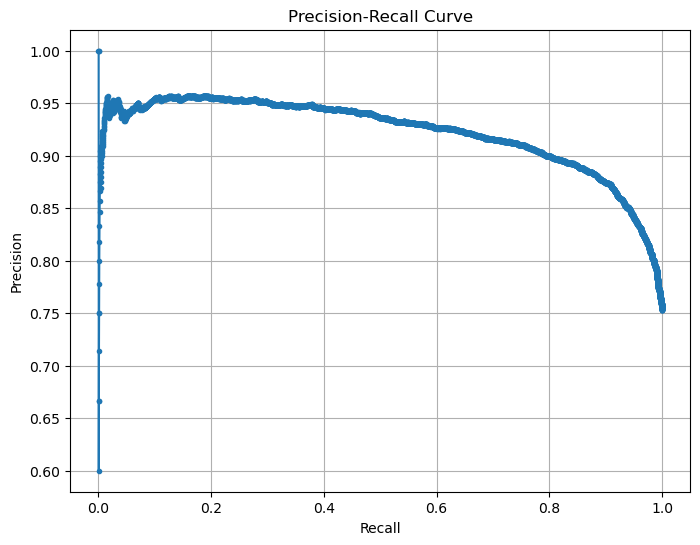

In [93]:
mlp_model = MLPClassifier(hidden_layer_sizes=(100,), activation='relu', solver='adam', random_state=42)
mlp_model.fit(X_train, y_train)

y_proba = mlp_model.predict_proba(X_test)[:, 1]
precision, recall, _ = precision_recall_curve(y_test, y_proba)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.grid(True)
plt.show()

## Gradient Boosting Report

In [94]:
report = classification_report(y_test, y_pred)
print(report)

with open(file_path, "a") as file:
    file.write("Gradient Boosting Report\nFalse Output Removed: " + str(false_output_removed) + "\n" + report + "\n\n")

print("Classification report saved to:", file_path)

              precision    recall  f1-score   support

           0       0.74      0.53      0.62      1786
           1       0.86      0.94      0.90      5444

    accuracy                           0.84      7230
   macro avg       0.80      0.73      0.76      7230
weighted avg       0.83      0.84      0.83      7230

Classification report saved to: classification_report.txt
